# Credit Risk Modeling: LGD & EAD Model
*Author: Shawn Sun*
<br>
*Date: 2021/01/29*

## 1. Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
loan_data_preprocessed_backup = pd.read_csv('loan_data_2007_2014_preprocessed.csv')
loan_data_preprocessed = loan_data_preprocessed_backup.copy()

E:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (21,49) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 2. Explore Data

In [3]:
loan_data_preprocessed.columns.values

array(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'member_id', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_join

In [4]:
loan_data_preprocessed.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,1,0,1
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,1,0,1
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,1,0,1


In [5]:
loan_data_defaults = \
loan_data_preprocessed\
[loan_data_preprocessed['loan_status'].isin(['Charged Off',
                                             'Does not meet the credit policy. Status:Charged Off'])]
# Take only the accounts that were charged-off (written-off) as defaulted accounts

In [6]:
loan_data_defaults.shape

(43236, 209)

In [7]:
pd.options.display.max_rows = None

In [8]:
loan_data_defaults.isnull().sum()

Unnamed: 0                                                             0
Unnamed: 0.1                                                           0
id                                                                     0
member_id                                                              0
loan_amnt                                                              0
funded_amnt                                                            0
funded_amnt_inv                                                        0
term                                                                   0
int_rate                                                               0
installment                                                            0
grade                                                                  0
sub_grade                                                              0
emp_title                                                           3287
emp_length                                         

## 3. Process Variables

### 3.1 Independent Variables

In [9]:
# Fill the missing values with zero
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)

E:\Anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


### 3.2 Dependent Variables

In [10]:
# The dependent variable for the LGD model: recovery rate
# = the ratio of recoveries and funded amount
loan_data_defaults['recovery_rate'] = \
loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']
loan_data_defaults['recovery_rate'].describe()

<ipython-input-10-7bb2f588252a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = \


count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

In [11]:
# Set the rates within [0,1]
loan_data_defaults['recovery_rate'] = \
np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = \
np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'].describe()

<ipython-input-11-e2d19d7447e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = \
<ipython-input-11-e2d19d7447e7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = \


count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

In [12]:
# The dependent variable for the EAD model: credit conversion factor.
# =the ratio of the difference of the amount 
#  used at the moment of default to the total funded amount.
loan_data_defaults['CCF'] = \
(loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp'])\
/ loan_data_defaults['funded_amnt']
loan_data_defaults['CCF'].describe()

<ipython-input-12-e8aa4f1cbb05>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['CCF'] = \


count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

In [13]:
loan_data_defaults.to_csv('loan_data_defaults.csv')

### 3.2 Explore Dependent Variables

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

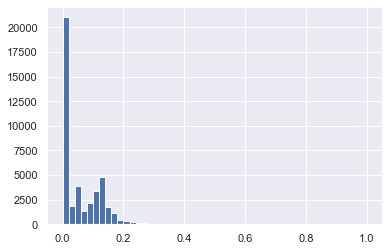

In [15]:
plt.hist(loan_data_defaults['recovery_rate'], bins = 50);

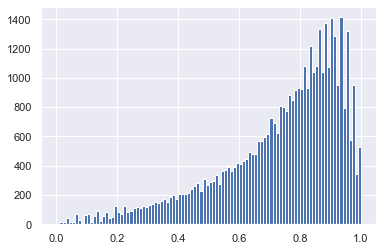

In [16]:
plt.hist(loan_data_defaults['CCF'], bins = 100);

In [17]:
# Create new variable which is 0 if recovery rate is 0 and 1 otherwise
loan_data_defaults['recovery_rate_0_1'] = \
np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)
loan_data_defaults['recovery_rate_0_1'].head()

<ipython-input-17-f7724a1bbe90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate_0_1'] = \


1     1
8     1
9     1
12    1
14    1
Name: recovery_rate_0_1, dtype: int32

## 4. LGD Model

### 4.1 Splitting Data

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, \
lgd_targets_stage_1_train, lgd_targets_stage_1_test = \
train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate',
                                          'recovery_rate_0_1', 'CCF'], axis = 1), 
                 loan_data_defaults['recovery_rate_0_1'], test_size = 0.2, random_state = 42)

### 4.2 Preparing the Inputs

In [20]:
# List of all independent variables for the models
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [21]:
# List of the dummy variable reference categories. 
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [22]:
# Keep only the variabes needed
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis = 1)

In [23]:
# Check for missing values
lgd_inputs_stage_1_train.isnull().sum()

grade:A                                0
grade:B                                0
grade:C                                0
grade:D                                0
grade:E                                0
grade:F                                0
home_ownership:MORTGAGE                0
home_ownership:NONE                    0
home_ownership:OTHER                   0
home_ownership:OWN                     0
verification_status:Not Verified       0
verification_status:Source Verified    0
purpose:car                            0
purpose:debt_consolidation             0
purpose:educational                    0
purpose:home_improvement               0
purpose:house                          0
purpose:major_purchase                 0
purpose:medical                        0
purpose:moving                         0
purpose:other                          0
purpose:renewable_energy               0
purpose:small_business                 0
purpose:vacation                       0
purpose:wedding 

## Stage 1: Logistic Regression

### 4.3 Estimating the model

In [24]:
# P values for sklearn logistic regression.

# Class to display p-values for logistic regression in sklearn.

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        #self.z_scores = z_scores
        self.p_values = p_values
        #self.sigma_estimates = sigma_estimates
        #self.F_ij = F_ij

In [25]:
reg_lgd_st_1 = LogisticRegression_with_p_values()

In [26]:
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

E:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
feature_name = lgd_inputs_stage_1_train.columns.values

In [28]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_1.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table.head()

#Note: most of the variables aren't statistically significant
# throwing them out won't affect the predicting power
# but we can keep them to save us effort

,Feature name,Coefficients,p_values
0,Intercept,-0.000128,NaN
1,grade:A,-0.000016,0.999852
2,grade:B,-0.000088,0.998970
3,grade:C,-0.000163,0.998016
4,grade:D,0.000019,0.999774


### 4.4 Testing the model

In [29]:
# Keep only the needed variables
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]
lgd_inputs_stage_1_test = \
lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)

In [30]:
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.
y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)
y_hat_test_lgd_stage_1

array([1, 1, 0, ..., 1, 1, 1])

In [31]:
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)
y_hat_test_proba_lgd_stage_1

array([[0.41533282, 0.58466718],
       [0.38989804, 0.61010196],
       [0.51756719, 0.48243281],
       ...,
       [0.4662346 , 0.5337654 ],
       [0.42105712, 0.57894288],
       [0.47678806, 0.52321194]])

In [32]:
# Take only the probability of recovery rate > 0
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[: ][: , 1]
y_hat_test_proba_lgd_stage_1

array([0.58466718, 0.61010196, 0.48243281, ..., 0.5337654 , 0.57894288,
       0.52321194])

In [33]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test.copy()
lgd_targets_stage_1_test_temp.head()

178928    1
69814     1
101396    0
463268    1
253729    0
Name: recovery_rate_0_1, dtype: int32

In [34]:
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace = True)
lgd_targets_stage_1_test_temp.head()

0    1
1    1
2    0
3    1
4    0
Name: recovery_rate_0_1, dtype: int32

In [35]:
df_actual_predicted_probs = \
pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], axis = 1)
# Concatenates two dataframes
df_actual_predicted_probs.head()

,recovery_rate_0_1,0
0,1,0.584667
1,1,0.610102
2,0,0.482433
3,1,0.556293
4,0,0.401045


In [36]:
# Rename columns
df_actual_predicted_probs.columns = \
['lgd_targets_stage_1_test', 'y_hat_test_proba_lgd_stage_1']
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
0,1,0.584667
1,1,0.610102
2,0,0.482433
3,1,0.556293
4,0,0.401045


In [37]:
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
178928,1,0.584667
69814,1,0.610102
101396,0,0.482433
463268,1,0.556293
253729,0,0.401045


### 4.5 Estimating the accuracy of the model

In [38]:
tr = 0.5
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = \
np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1, 0)

In [39]:
cf_mtx = pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], 
                     df_actual_predicted_probs['y_hat_test_lgd_stage_1'], 
                     rownames = ['Actual'], colnames = ['Predicted'])
cf_mtx

Predicted,0,1
Actual,,
0,1021,2741
1,665,4221


In [40]:
cf_mtx_perc = cf_mtx / df_actual_predicted_probs.shape[0]
cf_mtx_perc

Predicted,0,1
Actual,,
0,0.118062,0.316952
1,0.076896,0.488090


In [41]:
# Calculate Accuracy of the model
acc_rate = cf_mtx_perc.iloc[0,0] + cf_mtx_perc.iloc[1,1]
acc_rate

0.6061517113783533

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score

In [43]:
fpr, tpr, thresholds = \
roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'], 
          df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
[fpr, tpr, thresholds]

[array([0.        , 0.        , 0.        , ..., 0.99946837, 0.99946837,
        1.        ]),
 array([0.00000000e+00, 2.04666394e-04, 4.09332788e-04, ...,
        9.99795334e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.88264835e+00, 8.82648351e-01, 8.63584256e-01, ...,
        2.10568544e-01, 1.82003185e-01, 4.56831205e-06])]

Text(0.5, 1.0, 'ROC curve')

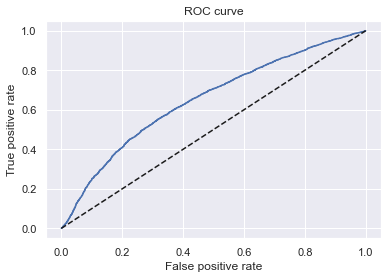

In [44]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [45]:
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], 
                      df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
AUROC

0.6511244247633932

In [46]:
# Save the Model
import pickle
pickle.dump(reg_lgd_st_1, open('lgd_model_stage_1.sav', 'wb'))

## Stage 2: Linear Regression

### 4.6 Estimating the model

In [47]:
lgd_stage_2_data = \
loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]
# Only rows where the original recovery rate variable is greater than one

In [48]:
# LGD model stage 2 datasets: how much more than 0 is the recovery rate
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, \
lgd_targets_stage_2_train, lgd_targets_stage_2_test = \
train_test_split(lgd_stage_2_data.drop(['good_bad', 'recovery_rate',
                                        'recovery_rate_0_1', 'CCF'], axis = 1), 
                 lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)

In [49]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [50]:
# Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
import scipy.stats as stat

# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [51]:
import scipy.stats as stat

class LinearRegression(linear_model.LinearRegression):
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
        self.t = self.coef_ / se
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [52]:
# Keep the needed variables
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

In [53]:
reg_lgd_st_2 = LinearRegression()
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)

LinearRegression()

In [54]:
feature_name = lgd_inputs_stage_2_train.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_2.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values.round(3)
summary_table.head()

,Feature name,Coefficients,p_values
0,Intercept,0.240686,NaN
1,grade:A,-0.068269,0.0
2,grade:B,-0.050836,0.0
3,grade:C,-0.037481,0.0
4,grade:D,-0.027173,0.0


### 4.7 Model Evaluation

In [55]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)

In [56]:
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)

In [57]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test.copy()

In [58]:
lgd_targets_stage_2_test_temp = \
lgd_targets_stage_2_test_temp.reset_index(drop = True)

In [59]:
# Calculate the correlation between actual and predicted values.
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()

,recovery_rate,0
recovery_rate,1.000000,0.307996
0,0.307996,1.000000


E:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='recovery_rate', ylabel='Density'>

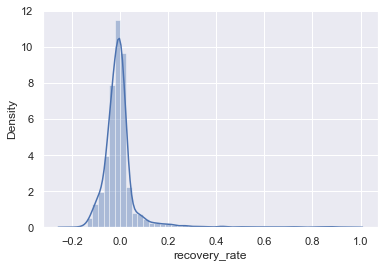

In [60]:
# Plot the distribution of the residuals.
sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)

In [61]:
# Save the model
pickle.dump(reg_lgd_st_2, open('lgd_model_stage_2.sav', 'wb'))

### 4.8 Combining Stage 1 and Stage 2

In [62]:
# Include all records
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)

In [63]:
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all
# Combine the predictions of the models from the two stages
y_hat_test_lgd

array([0.1193906 , 0.09605635, 0.        , ..., 0.12078611, 0.11587422,
       0.15667447])

In [64]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.086777
std,0.049741
min,-0.007634
25%,0.064223
50%,0.100906
75%,0.122950
max,0.236973


In [65]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.086779
std,0.049737
min,0.000000
25%,0.064223
50%,0.100906
75%,0.122950
max,0.236973


## 5. EAD Model

### 5.1 Estimation and Interpretation

In [66]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = \
train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate',
                                          'recovery_rate_0_1', 'CCF'], axis = 1), 
                 loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)

In [67]:
ead_inputs_train = ead_inputs_train[features_all]
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)

In [68]:
reg_ead = LinearRegression()
reg_ead.fit(ead_inputs_train, ead_targets_train)

LinearRegression()

In [69]:
feature_name = ead_inputs_train.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_ead.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table.head()

,Feature name,Coefficients,p_values
0,Intercept,1.109746,NaN
1,grade:A,-0.303003,0.0
2,grade:B,-0.236428,0.0
3,grade:C,-0.172023,0.0
4,grade:D,-0.119847,0.0


### 5.2 Model Validation

In [70]:
ead_inputs_test = ead_inputs_test[features_all]
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)

In [71]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test)

In [72]:
ead_targets_test_temp = ead_targets_test.copy()

In [73]:
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)

In [74]:
# Calculate the correlation
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()

,CCF,0
CCF,1.000000,0.530654
0,0.530654,1.000000


E:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='CCF', ylabel='Density'>

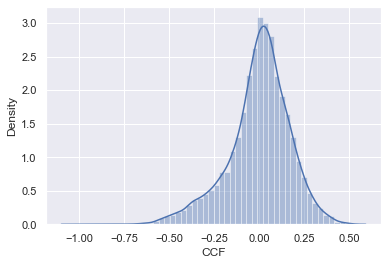

In [75]:
sns.distplot(ead_targets_test - y_hat_test_ead)

In [76]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736013
std,0.105194
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.161088


In [77]:
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.735992
std,0.105127
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.000000


## 6. Expected Loss

### 6.1 Preprocess Data

In [78]:
loan_data_preprocessed.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,1,0,1
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,1,0,1
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,1,0,1


In [79]:
loan_data_preprocessed.isnull().sum()

Unnamed: 0                                                              0
Unnamed: 0.1                                                            0
id                                                                      0
member_id                                                               0
loan_amnt                                                               0
funded_amnt                                                             0
funded_amnt_inv                                                         0
term                                                                    0
int_rate                                                                0
installment                                                             0
grade                                                                   0
sub_grade                                                               0
emp_title                                                           27588
emp_length                            

In [80]:
# Fill the missing values
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)

In [81]:
# Keep the needed variables
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

### 6.2 LGD

In [82]:
# Apply LGD stage 1 - Logistic regression model
loan_data_preprocessed['recovery_rate_st_1'] = \
reg_lgd_st_1.model.predict(loan_data_preprocessed_lgd_ead)

In [83]:
# Apply LGD stage 2 - Linear regression model
loan_data_preprocessed['recovery_rate_st_2'] = \
reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)

In [84]:
# Multiply the result the calculate the recovery rate
loan_data_preprocessed['recovery_rate'] = \
loan_data_preprocessed['recovery_rate_st_1'] * \
loan_data_preprocessed['recovery_rate_st_2']

In [85]:
# Make sure all values between 0 and 1
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])

In [86]:
# Calculate the LGD
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']
loan_data_preprocessed['LGD'].describe()

count    466285.000000
mean          0.920118
std           0.057379
min           0.371789
25%           0.873563
50%           0.899121
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

### 6.3 EAD

In [87]:
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)

In [88]:
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])

In [89]:
loan_data_preprocessed['EAD'] = \
loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']
# Calculate estimated EAD. 
# Estimated EAD equals estimated CCF multiplied by funded amount.
loan_data_preprocessed['EAD'].describe()

count    466285.000000
mean      10814.846760
std        6935.184562
min         190.347372
25%        5495.101413
50%        9208.479591
75%       14692.844549
max       35000.000000
Name: EAD, dtype: float64

In [90]:
loan_data_preprocessed.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad,recovery_rate_st_1,recovery_rate_st_2,recovery_rate,LGD,CCF,EAD
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,1,0,1,1,0.086271,0.086271,0.913729,0.589922,2949.608449
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,1,0,0,1,0.084518,0.084518,0.915482,0.777773,1944.433378
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,1,0,1,1,0.080516,0.080516,0.919484,0.658306,1579.934302
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,1,0,1,1,0.095076,0.095076,0.904924,0.660656,6606.559612
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,1,0,1,1,0.088547,0.088547,0.911453,0.708211,2124.631667


### 6.4 PD

In [91]:
loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv')
loan_data_inputs_test = pd.read_csv('loan_data_inputs_test.csv')
# Import data to apply the PD model

In [92]:
loan_data_inputs_pd = \
pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0)
# Concatenate the two dataframes along the rows.
loan_data_inputs_pd.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
0,427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,...,1,0,0,1,0,0,0,0,0,0
1,206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,...,0,0,0,1,0,0,0,0,0,0
2,136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,...,0,0,0,1,0,0,0,0,0,0
3,412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,...,0,0,0,1,0,0,0,0,0,0
4,36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,...,0,1,0,1,0,0,0,0,0,0


In [93]:
loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')
loan_data_inputs_pd.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,...,1,0,0,1,0,0,0,0,0,0
206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,...,0,0,0,1,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,...,0,0,0,1,0,0,0,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,...,0,0,0,1,0,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,...,0,1,0,1,0,0,0,0,0,0


In [94]:
features_all_pd = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86']

In [95]:
ref_categories_pd = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [96]:
# Keep the needed variables
loan_data_inputs_pd_temp = loan_data_inputs_pd[features_all_pd]
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1)

In [97]:
loan_data_inputs_pd_temp.shape

(466285, 84)

In [98]:
# Import PD model
import pickle
reg_pd = pickle.load(open('pd_model.sav', 'rb'))

In [99]:
# Only get the probability of defaults
pd_value = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]
pd_value

array([0.02958552, 0.0921482 , 0.03735908, ..., 0.02678659, 0.04020859,
       0.04763349])

In [100]:
loan_data_inputs_pd['PD'] = pd_value
loan_data_inputs_pd['PD'].head()

Unnamed: 0
427211    0.029586
206088    0.092148
136020    0.037359
412305    0.204328
36159     0.200847
Name: PD, dtype: float64

In [101]:
loan_data_inputs_pd['PD'].describe()

count    466285.000000
mean          0.109307
std           0.070917
min           0.007314
25%           0.056064
50%           0.093492
75%           0.146558
max           0.635818
Name: PD, dtype: float64

In [102]:
# Concate PD with LGD and EAD
loan_data_preprocessed_new = \
pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis = 1)
loan_data_preprocessed_new.head()

,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,PD
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,1,0,1,0,0,0,0,0,0,0.164761
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,1,0,0,0,0,0,0,0.282340
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,1,0,0,0,0,0,0,0.229758
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,1,0,0,0,0,0,0,0.208892
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,1,0,0,0,0,0,0,0.129556


### 6.5 EL

In [103]:
loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * \
loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']
# Calculate Expected Loss. EL = PD * LGD * EAD

In [104]:
loan_data_EL = loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']]

In [105]:
loan_data_EL.head()

,funded_amnt,funded_amnt,PD,LGD,EAD,EL
0,5000,5000,0.164761,0.913729,2949.608449,444.053181
1,2500,2500,0.282340,0.915482,1944.433378,502.592155
2,2400,2400,0.229758,0.919484,1579.934302,333.775277
3,10000,10000,0.208892,0.904924,6606.559612,1248.848487
4,3000,3000,0.129556,0.911453,2124.631667,250.884853


In [106]:
loan_data_EL['funded_amnt'].describe()

,funded_amnt,funded_amnt
count,466285.000000,466285.000000
mean,14291.801044,14291.801044
std,8274.371300,8274.371300
min,500.000000,500.000000
25%,8000.000000,8000.000000
50%,12000.000000,12000.000000
75%,20000.000000,20000.000000
max,35000.000000,35000.000000


In [107]:
total_EL = loan_data_EL['EL'].sum()
total_EL

501574040.5091934

In [108]:
total_funded = loan_data_EL['funded_amnt'].sum()[0]
total_funded

6664052450

In [109]:
ratio_EL = total_EL / total_funded
ratio_EL

0.07526562017218118

# --------------------------------END-----------------------------------